# **IMPORTS**

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import math
import nltk
import os
import re

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models.fasttext import FastText
from gensim.models import KeyedVectors


from sklearn.model_selection import train_test_split as tts
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

```
⠀⠀⠀⠀⠀⠀⣀⣤⡤
⠀⠀⠀⠀⢀⣾⣿⠋
⠀⠀⠀⣠⣾⣿⡟
⠀⠀⢸⠛⠉⢹⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡠⠄⠠⣀
⠀⠀⡘⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⣠⠖⠉⠀⠀⠀⣾⣿⣦⡀
⠀⠀⡇⠀⠀⠀⢡⠄⠀⠀⣀⣀⣀⣠⠊⠀⠀⠀⠀⡠⠞⠛⠛⠛⠛⡀
⠀⠀⢃⠀⠀⠀⠀⠗⠚⠉⠉⠀⠈⠁⠀⠀⠀⢀⡔⠁⠀
⠀⠀⠸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣴⣶⣄⠲⡎
⠀⠀⠀⠃⠀⠀⢠⣤⡀⠀⠀⠀⠀⣿⣿⣿⠀⠘⡄
⠀⠀⠀⡆⠀⠀⣿⣿⡇⠀⠀⠀⠀⠈⠛⠉⣴⣆⢹⡄
⠀⠀⠀⣇⢰⡧⣉⡉⠀⠀⢀⡀⠀⣀⣀⣠⣿⡷⢠⡇
⠀⠀⠀⢻⠘⠃⠈⠻⢦⠞⠋⠙⠺⠋⠉⠉⠉⢡⠟
⠀⠀⠀⠀⠳⢄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠋⠀⠀
```

# **SETTINGS**
---

In [10]:
# Matplotlib inline to visualize Matplotlib graphs
%matplotlib inline

# Configuration to set so that all the Seaborn figures come out with this size
%config Inlinebackend.figure_format= 'retina'

In [11]:
# Set the Seaborn context to "poster" for larger text and figures
sns.set_context("poster")

# Set the default figure size for Seaborn plots
sns.set(rc={"figure.figsize": (12., 6.)})

# Set the Seaborn style to "whitegrid" for a white background with gridlines
sns.set_style("whitegrid")

In [12]:
# Set the max displayable columns to max
pd.set_option('display.max_columns', None)

In [13]:
# Activates XLA (for JIT compiler)
os.environ["TF_XLA_FLAGS"]= "--tf_xla_enable_xla_devices"

# Uses the right memory when using GPU
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]= "true"

# **DOCUMENTATION**
---

[placeholder](https://google.com)

# **DATA**

---

In [14]:
# Data loading
train_path= "data/training_data.csv"
test_path=  "data/testing_data.csv"

# Since the csv separates the columns with " " instead of a comma, we define <sep> as None
# We use engine= "python" to avoid warning about \c or \b imports from text
train_data=  pd.read_csv(train_path, names= ["label", "text"], header=None, sep=None, engine= "python")
test_data=   pd.read_csv(test_path, names= ["label", "text"], header=None, sep=None, engine= "python")

In [15]:
# Dataframe for training creation
df_train= pd.DataFrame(train_data)
df_train.head(3)

,label,text
0,﻿0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...


In [16]:
# Dataframe for testing creation
df_test= pd.DataFrame(test_data)
df_test.head(3)

,label,text
0,﻿2,copycat muslim terrorist arrested with assault...
1,2,wow! chicago protester caught on camera admits...
2,2,germany's fdp look to fill schaeuble's big shoes


>`0` is real new, `1` is fake new, `2` is the prediction we need to do at the end

# **DATA CHECKING**

---

In [9]:
# 34k rows of headers articles
# 2 columns: text and the label.
print(f"Rows: {df_train.shape[0]}\nColumns: {df_train.shape[1]}")

Rows: 34152
Columns: 2


In [10]:
df_train.isnull().sum()

label    0
text     0
dtype: int64

In [13]:
df_train.label.unique()

array(['\ufeff0', '0', '1'], dtype=object)

In [17]:
df_train.label.value_counts()

label
0     17571
1     16580
﻿0        1
Name: count, dtype: int64

> that bom value will be cleaned later; not balance needed for our df

In [14]:
df_train.sample(1)

,label,text
28091,1,kerry trip to cuba for rights dialogue cancele...


# **FUNCTIONS**

---

In [17]:
def clean_text(text):
  text= text.lower()                      # ensures lowercase
  text= re.sub(r"\t", " ", text)          # erases \t from text
  text= re.sub(r"[^a-z0-9\s]", "", text)  # erases symbols
  text= re.sub(r"\s+", " ", text).strip() # erases initial-end blank spaces

  return text

In [18]:
def lemmatize_text(text):
  lemma= WordNetLemmatizer()                        # creates lemmatizer
  stop_words= set(stopwords.words('english'))       # load stopwords on english

  words= text.split()                               # split the text if not
  words= [lemma.lemmatize(w) for w in words         # apply lemmatizer to all words
           if w not in stop_words and len(w) > 2]
  
  return " ".join(words)

In [19]:
def train_and_evaluate(model ,model_name, X_train, X_test, y_train, y_test):
  print(f"Training {model_name}\n{50*"-"}")

  model.fit(X_train, y_train)   # fit the model
  y_pred= model.predict(X_test) # predict with X_test

  # metrics
  print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
  print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))
  print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

In [ ]:
def clean_label(label):
  # y is messed with '\ufeff0' dtype
  return label.astype(str).str.replace(r"[^0-9]", "", regex=True).astype(int)

In [ ]:
def split_data(X, y):
  X_train, X_test, y_train, y_test= tts(X, y, test_size= .2, stratify= y,  random_state= 69)
  print(f"X-train: {X_train.shape}\nX-test: {X_test.shape}\ny-train: {y_train.shape}\ny-test: {y_test.shape}")
  
  return X_train, X_test, y_train, y_test

#### Train/Test Split Failure

**Error:**  
`ValueError: The least populated class in y has only 1 member`

**Cause:**  
The dataset contained a hidden label (`"﻿0"`, BOM character) with only **one sample**.  
`stratify` requires **at least two samples per class**, so the split failed.

**Fix:**  
Clean the labels before splitting:

```python
y = y.astype(str).str.replace(r"[^0-9]", "", regex=True).astype(int)
```


In [21]:
def fit_transform_tfidf(X_train, X_test, tfidf_vectorizer):
  X_train_tfidf= tfidf_vectorizer.fit_transform(X_train)
  X_test_tfidf=  tfidf_vectorizer.transform(X_test)

  print(f"TF-IDF shape: {X_train_tfidf.shape}")
  return X_train_tfidf, X_test_tfidf

In [22]:
def run_pipeline(X, y, model, model_name, tfidf_vectorizer=None, dataset_name="Raw"):
  # 0. verbose
  print(f"--- Running Pipeline: {dataset_name} ---")

  # 1. split
  X_train, X_test, y_train, y_test= split_data(X, y)

  # 2. Transform
  if tfidf_vectorizer:
    X_train= tfidf_vectorizer.fit_transform(X_train)
    X_test=  tfidf_vectorizer.transform(X_test)

  print("") # !!!
  
  # 3. model train and predict
  train_and_evaluate(model, model_name= model_name, X_train= X_train, X_test= X_test, y_train= y_train, y_test= y_test)

In [23]:
def sentence_to_vector(sentence, model, dim= 300):
  words=   sentence.split()
  vectors= [model[w] for w in words if w in model]
  if len(vectors) == 0:
    return np.zeros(dim)
  return np.mean(vectors, axis= 0)

# **DATA PRRE-PROCESSING**

---

## Cleaning data

In [24]:
df_train["clean_text"]= df_train["text"].apply(clean_text)
df_train["lemmatized_text"]= df_train["clean_text"].apply(lemmatize_text)

In [24]:
df_train.sample(3)

,label,text,clean_text,lemmatized_text
3224,0,conservative calls president obama a ‚muslim‚ ...,conservative calls president obama a muslim ov...,conservative call president obama muslim resol...
12263,0,the numbers are in: here‚s how the catholics v...,the numbers are in heres how the catholics vot...,number here catholic voted historic election
18587,1,u.s. house clears path for tax bill with budge...,us house clears path for tax bill with budget ...,house clear path tax bill budget approval


## Split the data

In [31]:
y= df_train.label
y= clean_label(y)
y.dtype

dtype('int32')

In [ ]:
X= df_train["text"]
X_clean= df_train["clean_text"]
X_lemma= df_train["lemmatized_text"]
# call for split_data(X, y) when requires (we're gonna do some tests)

In [49]:
X_train, X_test, y_train, y_test= split_data(X= X, y= y)

X-train: (27321,)
X-test: (6831,)
y-train: (27321,)
y-test: (6831,)


In [34]:
y.value_counts()

label
0     17571
1     16580
﻿0        1
Name: count, dtype: int64

## **VECTORIZATION I**

We know about `BoW`, but wince `TfidfVectorizer` is just better we don't want to waste time using a method that is just worse. We'll be using directly TfidfVectorizer.

In [44]:
tfidf_vectorizer= TfidfVectorizer(
  lowercase=    True,       # ensures lowercase
 #stop_words=   "english",  # stopwords for english lang !!! MAY WORK GRONG WITH LEMMATIZED DATA
  max_features= 5000,       # 5000 more common words
  ngram_range=  (1, 2),     # unigrams and bigrams
  max_df=       .9,         # ignore words that appears more than 90% on all documents
  min_df=       5           # ignore words that appears more than 5 times in different documents
)

In [52]:
X_train_tfidf, X_test_tfidf= fit_transform_tfidf(X_test= X_test, X_train= X_train, tfidf_vectorizer= tfidf_vectorizer)

TF-IDF shape: (27321, 5000)


# **MODEL TEST**

---

## Using LogisticRegression

### Using original data on LogisticRegression

In [65]:
lr_model= LogisticRegression(max_iter= 1000, random_state= 69)

In [66]:
X_train, X_test, y_train, y_test= split_data(X= X, y= y)

X-train: (27321,)
X-test: (6831,)
y-train: (27321,)
y-test: (6831,)


In [67]:
X_train_tfidf, X_test_tfidf= fit_transform_tfidf(X_test= X_test, X_train= X_train, tfidf_vectorizer= tfidf_vectorizer)

TF-IDF shape: (27321, 5000)


In [68]:
train_and_evaluate(lr_model, "Logistic Regression - no data treatment",  X_train_tfidf, X_test_tfidf, y_train= y_train, y_test= y_test)

Training Logistic Regression - no data treatment
--------------------------------------------------
Accuracy Score: 0.9392475479432001
              precision    recall  f1-score   support

        Fake       0.95      0.93      0.94      3515
        Real       0.93      0.95      0.94      3316

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831

Confusion Matrix:
[[3282  233]
 [ 182 3134]]


### Using cleaned data on LogisticRegression

In [69]:
X_train, X_test, y_train, y_test= split_data(X= X_clean, y= y)

X-train: (27321,)
X-test: (6831,)
y-train: (27321,)
y-test: (6831,)


In [70]:
X_train_tfidf, X_test_tfidf= fit_transform_tfidf(X_test= X_test, X_train= X_train, tfidf_vectorizer= tfidf_vectorizer)

TF-IDF shape: (27321, 5000)


In [71]:
train_and_evaluate(lr_model, "Logistic Regression - cleaned data",  X_train_tfidf, X_test_tfidf, y_train= y_train, y_test= y_test)

Training Logistic Regression - cleaned data
--------------------------------------------------
Accuracy Score: 0.9347094129702825
              precision    recall  f1-score   support

        Fake       0.94      0.93      0.94      3515
        Real       0.93      0.94      0.93      3316

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831

Confusion Matrix:
[[3266  249]
 [ 197 3119]]


### Using lemmatized text on LogisticRegression

In [72]:
X_train, X_test, y_train, y_test= split_data(X= X_lemma, y= y)

X-train: (27321,)
X-test: (6831,)
y-train: (27321,)
y-test: (6831,)


In [73]:
X_train_tfidf, X_test_tfidf= fit_transform_tfidf(X_test= X_test, X_train= X_train, tfidf_vectorizer= tfidf_vectorizer)

TF-IDF shape: (27321, 5000)


In [74]:
train_and_evaluate(lr_model, "Logistic Regression - lemmatized data",  X_train_tfidf, X_test_tfidf, y_train= y_train, y_test= y_test)

Training Logistic Regression - lemmatized data
--------------------------------------------------
Accuracy Score: 0.9229980969111404
              precision    recall  f1-score   support

        Fake       0.93      0.92      0.92      3515
        Real       0.91      0.93      0.92      3316

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831

Confusion Matrix:
[[3226  289]
 [ 237 3079]]


## Using `run_pipeline` on MultinomialNB

In [79]:
nb_model= MultinomialNB()

In [90]:
run_pipeline(X= X, y= y, model= nb_model, model_name= "MultinomialNB", tfidf_vectorizer= tfidf_vectorizer, dataset_name= "Raw")

--- Running Pipeline: Raw ---
X-train: (27321,)
X-test: (6831,)
y-train: (27321,)
y-test: (6831,)

Training MultinomialNB
--------------------------------------------------
Accuracy Score: 0.9276826233347972
              precision    recall  f1-score   support

        Fake       0.92      0.94      0.93      3515
        Real       0.94      0.91      0.92      3316

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831

Confusion Matrix:
[[3306  209]
 [ 285 3031]]


In [91]:
run_pipeline(X= X_clean, y= y, model= nb_model, model_name= "MultinomialNB", tfidf_vectorizer= tfidf_vectorizer, dataset_name= "Cleaned")

--- Running Pipeline: Cleaned ---
X-train: (27321,)
X-test: (6831,)
y-train: (27321,)
y-test: (6831,)

Training MultinomialNB
--------------------------------------------------
Accuracy Score: 0.9254867515737081
              precision    recall  f1-score   support

        Fake       0.92      0.94      0.93      3515
        Real       0.93      0.91      0.92      3316

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831

Confusion Matrix:
[[3294  221]
 [ 288 3028]]


In [92]:
run_pipeline(X= X_lemma, y= y, model= nb_model, model_name= "MultinomialNB", tfidf_vectorizer= tfidf_vectorizer, dataset_name= "Lemmatized")

--- Running Pipeline: Lemmatized ---
X-train: (27321,)
X-test: (6831,)
y-train: (27321,)
y-test: (6831,)

Training MultinomialNB
--------------------------------------------------
Accuracy Score: 0.918020787586005
              precision    recall  f1-score   support

        Fake       0.91      0.93      0.92      3515
        Real       0.92      0.91      0.91      3316

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831

Confusion Matrix:
[[3264  251]
 [ 309 3007]]


## Using `run_pipeline` on RandomForestClassifier

In [94]:
rfr_model= RandomForestClassifier(random_state= 69)

In [96]:
run_pipeline(X= X, y= y, model= rfr_model, model_name= "RandomForest", tfidf_vectorizer= tfidf_vectorizer, dataset_name= "Raw")

--- Running Pipeline: Raw ---
X-train: (27321,)
X-test: (6831,)
y-train: (27321,)
y-test: (6831,)

Training RandomForest
--------------------------------------------------
Accuracy Score: 0.9158249158249159
              precision    recall  f1-score   support

        Fake       0.92      0.92      0.92      3515
        Real       0.91      0.92      0.91      3316

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831

Confusion Matrix:
[[3217  298]
 [ 277 3039]]


In [97]:
run_pipeline(X= X_clean, y= y, model= rfr_model, model_name= "RandomForest", tfidf_vectorizer= tfidf_vectorizer, dataset_name= "Clean")

--- Running Pipeline: Clean ---
X-train: (27321,)
X-test: (6831,)
y-train: (27321,)
y-test: (6831,)

Training RandomForest
--------------------------------------------------
Accuracy Score: 0.9130434782608695
              precision    recall  f1-score   support

        Fake       0.92      0.91      0.91      3515
        Real       0.91      0.92      0.91      3316

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831

Confusion Matrix:
[[3197  318]
 [ 276 3040]]


In [98]:
run_pipeline(X= X_lemma, y= y, model= rfr_model, model_name= "RandomForest", tfidf_vectorizer= tfidf_vectorizer, dataset_name= "Lemmatized")

--- Running Pipeline: Lemmatized ---
X-train: (27321,)
X-test: (6831,)
y-train: (27321,)
y-test: (6831,)

Training RandomForest
--------------------------------------------------
Accuracy Score: 0.9011857707509882
              precision    recall  f1-score   support

        Fake       0.90      0.90      0.90      3515
        Real       0.90      0.90      0.90      3316

    accuracy                           0.90      6831
   macro avg       0.90      0.90      0.90      6831
weighted avg       0.90      0.90      0.90      6831

Confusion Matrix:
[[3179  336]
 [ 339 2977]]


## Using `run_pipeline` on XGBC

In [99]:
xgbc_model= XGBClassifier(random_state= 69)

In [100]:
run_pipeline(X= X, y= y, model= xgbc_model, model_name= "XGBClassifier", tfidf_vectorizer= tfidf_vectorizer, dataset_name= "Raw")

--- Running Pipeline: Raw ---
X-train: (27321,)
X-test: (6831,)
y-train: (27321,)
y-test: (6831,)

Training XGBClassifier
--------------------------------------------------
Accuracy Score: 0.9030888596105987
              precision    recall  f1-score   support

        Fake       0.94      0.86      0.90      3515
        Real       0.87      0.94      0.90      3316

    accuracy                           0.90      6831
   macro avg       0.91      0.90      0.90      6831
weighted avg       0.91      0.90      0.90      6831

Confusion Matrix:
[[3040  475]
 [ 187 3129]]


In [101]:
run_pipeline(X= X_clean, y= y, model= xgbc_model, model_name= "XGBClassifier", tfidf_vectorizer= tfidf_vectorizer, dataset_name= "Clean")

--- Running Pipeline: Clean ---
X-train: (27321,)
X-test: (6831,)
y-train: (27321,)
y-test: (6831,)

Training XGBClassifier
--------------------------------------------------
Accuracy Score: 0.9008929878495096
              precision    recall  f1-score   support

        Fake       0.94      0.86      0.90      3515
        Real       0.86      0.94      0.90      3316

    accuracy                           0.90      6831
   macro avg       0.90      0.90      0.90      6831
weighted avg       0.90      0.90      0.90      6831

Confusion Matrix:
[[3025  490]
 [ 187 3129]]


In [102]:
run_pipeline(X= X_lemma, y= y, model= xgbc_model, model_name= "XGBClassifier", tfidf_vectorizer= tfidf_vectorizer, dataset_name= "Lemmatized")

--- Running Pipeline: Lemmatized ---
X-train: (27321,)
X-test: (6831,)
y-train: (27321,)
y-test: (6831,)

Training XGBClassifier
--------------------------------------------------
Accuracy Score: 0.873078612209047
              precision    recall  f1-score   support

        Fake       0.93      0.82      0.87      3515
        Real       0.83      0.93      0.88      3316

    accuracy                           0.87      6831
   macro avg       0.88      0.87      0.87      6831
weighted avg       0.88      0.87      0.87      6831

Confusion Matrix:
[[2874  641]
 [ 226 3090]]


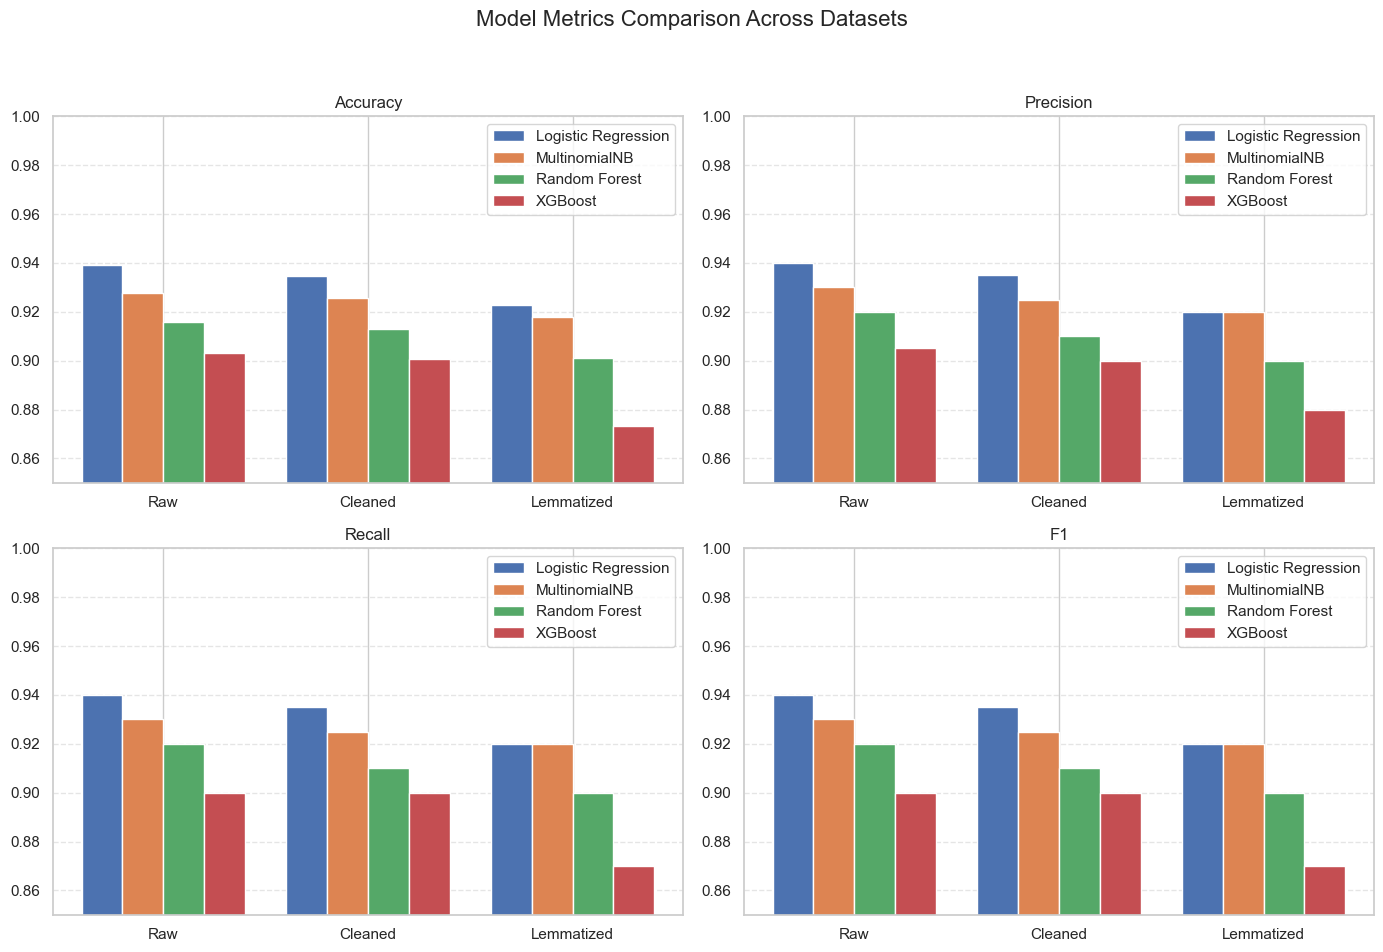

In [103]:
# <>! AI GENERATED CODE <>!
import matplotlib.pyplot as plt
import numpy as np

# Métricas ya conocidas
metrics = {
    "Logistic Regression": {
        "Raw":      {"accuracy":0.9392, "precision":0.94, "recall":0.94, "f1":0.94},
        "Cleaned":  {"accuracy":0.9347, "precision":0.935, "recall":0.935, "f1":0.935},
        "Lemmatized":{"accuracy":0.9230, "precision":0.92, "recall":0.92, "f1":0.92}
    },
    "MultinomialNB": {
        "Raw":      {"accuracy":0.9277, "precision":0.93, "recall":0.93, "f1":0.93},
        "Cleaned":  {"accuracy":0.9255, "precision":0.925, "recall":0.925, "f1":0.925},
        "Lemmatized":{"accuracy":0.9180, "precision":0.92, "recall":0.92, "f1":0.92}
    },
    "Random Forest": {
        "Raw":      {"accuracy":0.9158, "precision":0.92, "recall":0.92, "f1":0.92},
        "Cleaned":  {"accuracy":0.9130, "precision":0.91, "recall":0.91, "f1":0.91},
        "Lemmatized":{"accuracy":0.9012, "precision":0.90, "recall":0.90, "f1":0.90}
    },
    "XGBoost": {
        "Raw":      {"accuracy":0.9031, "precision":0.905, "recall":0.90, "f1":0.90},
        "Cleaned":  {"accuracy":0.9009, "precision":0.90, "recall":0.90, "f1":0.90},
        "Lemmatized":{"accuracy":0.8731, "precision":0.88, "recall":0.87, "f1":0.87}
    }
}

datasets = ["Raw", "Cleaned", "Lemmatized"]
models = list(metrics.keys())
metric_names = ["accuracy","precision","recall","f1"]

x = np.arange(len(datasets))
width = 0.2

fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()

for i, m_name in enumerate(metric_names):
    ax = axes[i]
    for j, model in enumerate(models):
        vals = [metrics[model][ds][m_name] for ds in datasets]
        ax.bar(x + j*width, vals, width=width, label=model)
    
    ax.set_title(m_name.capitalize())
    ax.set_xticks(x + width*1.5)
    ax.set_xticklabels(datasets)
    ax.set_ylim(0.85,1)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.legend()

plt.suptitle("Model Metrics Comparison Across Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**English version (short & clear):**

The raw text performs best overall across all models, with a stronger effect on Logistic Regression. The Cleaned and Lemmatized versions are the most problematic, especially for RandomForest and XGBC.

TF-IDF + Logistic Regression **MAY** work better with raw text because:

- It captures frequent word/bi-gram patterns that help distinguish Fake vs Real.
- Cleaning/Lemmatization may remove useful information that models use for generalization — e.g., “calls”, “calling”, “called” → “call”.
-  Removing stopwords **MAY** eliminate words that act as style or tone signals in Fake News.

# **WORD EMBEDDING**

---

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip

--2025-11-19 09:35:55--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-19 09:35:56--  https://nlp.stanford.edu/data/glove.6B.zip
Loaded CA certificate '/usr/ssl/certs/ca-bundle.crt'
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-19 09:35:56--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (82

In [ ]:
"""
can unzip directly on file explorer
import zipfile

with zipfile.ZipFile("glove.6B.zip", "r") as z:
  z.extractall("glove/")
"""

In [ ]:
# After loading glove.6B.300d.txt
glove= KeyedVectors.load_word2vec_format(
  "glove/glove.6B.300d.txt", binary=False, no_header=True
)

## Text to Vector using GloVe

In [50]:
X_vec= np.array([sentence_to_vector(text, glove) for text in df_train["clean_text"]])

y_vec= df_train["label"]
y_vec= clean_label(y_vec)

In [51]:
print(X_vec[69][69])
print(y_vec[69])

-0.1524277627468109
0


In [52]:
X_train_vec, X_test_vec, y_train_vec, y_test_vec= split_data(X_vec, y_vec)

X-train: (27321, 300)
X-test: (6831, 300)
y-train: (27321,)
y-test: (6831,)


## Testing on CLF

In [48]:
clf_model= LogisticRegression()

In [ ]:
train_and_evaluate(clf_model, "CLF", X_train_vec, X_test_vec, y_train_vec, y_test_vec)

Training CLF
--------------------------------------------------
Accuracy Score: 0.895330112721417
              precision    recall  f1-score   support

        Fake       0.89      0.90      0.90      3515
        Real       0.90      0.89      0.89      3316

    accuracy                           0.90      6831
   macro avg       0.90      0.90      0.90      6831
weighted avg       0.90      0.90      0.90      6831

Confusion Matrix:
[[3173  342]
 [ 373 2943]]


## Testing on RFR

In [54]:
rfr_model= RandomForestClassifier(random_state= 69)

In [55]:
train_and_evaluate(rfr_model, "RFR", X_train_vec, X_test_vec, y_train_vec, y_test_vec)

Training RFR
--------------------------------------------------
Accuracy Score: 0.8824476650563607
              precision    recall  f1-score   support

        Fake       0.90      0.87      0.88      3515
        Real       0.87      0.89      0.88      3316

    accuracy                           0.88      6831
   macro avg       0.88      0.88      0.88      6831
weighted avg       0.88      0.88      0.88      6831

Confusion Matrix:
[[3070  445]
 [ 358 2958]]


## Testing on XGBC

In [56]:
xgbc_model= XGBClassifier(random_state= 69)

In [57]:
train_and_evaluate(xgbc_model, "XGBC", X_train_vec, X_test_vec, y_train_vec, y_test_vec)

Training XGBC
--------------------------------------------------
Accuracy Score: 0.9077733860342556
              precision    recall  f1-score   support

        Fake       0.91      0.91      0.91      3515
        Real       0.91      0.90      0.90      3316

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831

Confusion Matrix:
[[3201  314]
 [ 316 3000]]


# **MODELING / TUNING**

---